# Supervised learning - Pombourg dataset

This notebook will be dedicated to the supervised classification of `(x, y, z)` points within the `Pombourg` dataset. As a prerequisite, the geometric features must be extracted for the point cloud as well as for every class sample with the following commands:

```sh
geo3d featurize -d data -i Pombourg.las -c r g b -t 500 -n 50 200 1500
geo3d featurize --label-scene -d data -i Pombourg_vegetation.las -c r g b -t 500 -n 50 200 1500
geo3d featurize --label-scene -d data -i Pombourg_falaise.las -c r g b -t 500 -n 50 200 1500
geo3d featurize --label-scene -d data -i Pombourg_eboulis.las -c r g b -t 500 -n 50 200 1500
```

As a reminder, the `Pombourg` dataset is composed of vegetation at the top, a large cliff at the middle of the scene, and some screes at the bottom; it looks as follows:
<img src="../docs/images/pombourg.png" width="250px">

## Imports

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import pickle

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [5]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
plt.style.use("seaborn-notebook")

In [7]:
from geo3dfeatures.classification import colorize_labels, train_predictive_model
from geo3dfeatures.extract import compute_tree, request_tree, extract
from geo3dfeatures.features import max_normalize, sum_normalize
from geo3dfeatures.io import load_features, read_las, write_las

## Global parameter setting

The file of interest must be set up for further data loading.

In [8]:
PREFIX_NAME = "Pombourg"
SCENE_FILE = PREFIX_NAME + ".las"
EBOULIS_FILE = PREFIX_NAME + "_eboulis.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"
DATADIR = Path("..", "data")

In [9]:
NEIGHBORHOOD_SIZES = [50, 200, 1500]

Some data column names (point coordinates, and RGB channels) are provided as follows:

In [10]:
COORDS = list("xyz")
COULEURS = list("rgb")

Then we define the labels for this dataset.

In [11]:
LABELS = {"eboulis": 0,
          "falaise": 1,
          "vegetation": 2}

## Data loading

### Raw point cloud

In [12]:
input_file_path = DATADIR / "input" / SCENE_FILE

In [13]:
rawdata = read_las(input_file_path)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [14]:
print("Raw data dimension: ", rawdata.shape)
rawdata.head()

Raw data dimension:  (672193, 6)


,x,y,z,r,g,b
0,1.977540e+06,5.242311e+06,902.684203,128.0,88.0,75.0
1,1.977540e+06,5.242311e+06,902.674986,117.0,78.0,66.0
2,1.977540e+06,5.242311e+06,902.731627,111.0,73.0,62.0
3,1.977538e+06,5.242330e+06,893.093306,147.0,135.0,131.0
4,1.977538e+06,5.242330e+06,893.049910,149.0,137.0,133.0


### Geometric features for the whole point cloud

The data is loaded for three different neighborhood sizes (50, 200, 1500). We further consider this dataset as the *testing* dataset.

In [15]:
features = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES)

[09:12:23] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features.h5
[09:12:23] utils._init_num_threads (INFO) - NumExpr defaulting to 4 threads.


In [16]:
print("Feature dimension: ", features.shape)
features.head()

Feature dimension:  (672193, 63)


,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,planarity_1500,scattering_1500,omnivariance_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500
0,1.977525e+06,5.242324e+06,891.317748,0.334604,0.664243,1.733842,0.292404,0.085410,2.381697,0.312858,...,0.349891,0.001678,0.061972,0.998322,0.582007,1122.339474,2.042213,114.635222,917.769528,0.274770
1,1.977525e+06,5.242324e+06,891.319029,0.345110,0.653892,1.709429,0.279770,0.082896,2.485200,0.315099,...,0.360852,0.001681,0.062153,0.998319,0.588088,1113.190733,2.001808,119.309563,913.282079,0.279151
2,1.977525e+06,5.242324e+06,891.354063,0.305694,0.692340,1.693528,0.298752,0.088161,2.555864,0.308114,...,0.354059,0.001692,0.062200,0.998308,0.584418,1117.264330,1.995458,120.070114,911.133084,0.280125
3,1.977525e+06,5.242324e+06,891.390135,0.295625,0.702156,1.661859,0.312424,0.092636,2.704780,0.304651,...,0.356062,0.001723,0.062601,0.998277,0.585683,1114.302199,1.969498,123.256208,904.931612,0.285944
4,1.977525e+06,5.242324e+06,891.310728,0.335228,0.663748,1.687403,0.271698,0.080073,2.583795,0.316415,...,0.361747,0.001637,0.061615,0.998363,0.588348,1113.519679,2.010107,118.326412,918.530668,0.275069


### Geometric features for the class samples

Parallely, we compute the geometric features for every class samples, by considering the whole scene for the kd-tree querying. A set of three neighborhood sizes is used in this way. We consider this composed dataset as the *training* dataset (labels are known by definition).

In [17]:
dfveg = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "vegetation")
dffalaise = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "falaise")
dfeboulis = load_features(DATADIR, PREFIX_NAME, NEIGHBORHOOD_SIZES, "eboulis")

[09:12:37] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features_vegetation.h5
[09:12:38] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features_falaise.h5
[09:12:40] io.load_features (INFO) - Recover features stored in ../data/output/Pombourg/features/features_eboulis.h5


Each sample dataset is associated with its corresponding label:

In [18]:
dfeboulis["label"] = LABELS["eboulis"]
dffalaise["label"] = LABELS["falaise"]
dfveg["label"] = LABELS["vegetation"]

Then we can concatenate all the sample datasets in one single dataframe.

In [19]:
datasets = pd.concat([dfeboulis, dffalaise, dfveg], axis=0)

In [20]:
print("Dataset shape: ", datasets.shape)
datasets.head()

Dataset shape:  (73651, 64)


,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,scattering_1500,omnivariance_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500,label
0,1.977537e+06,5.242329e+06,893.466154,0.102856,0.888538,1.302015,0.376617,0.105810,5.624278,0.868071,...,0.048439,0.182927,0.951561,0.790406,933.068215,1.133958,371.814129,521.100299,0.092416,0
1,1.977537e+06,5.242329e+06,893.412794,0.114306,0.877906,1.304379,0.397675,0.110456,5.593758,0.925616,...,0.043961,0.177248,0.956039,0.783676,943.017294,1.147080,363.356412,518.349456,0.077285,0
2,1.977537e+06,5.242329e+06,893.350233,0.069191,0.921435,1.308555,0.400131,0.109770,5.540366,0.973620,...,0.039202,0.170937,0.960798,0.776052,953.072758,1.147944,362.809773,517.876294,0.062526,0
3,1.977537e+06,5.242329e+06,893.513106,0.086685,0.903080,1.304417,0.364487,0.106054,5.593269,0.817127,...,0.051292,0.186419,0.948708,0.794486,929.007483,1.142140,366.506293,531.257561,0.103562,0
4,1.977537e+06,5.242329e+06,893.286024,0.041353,0.950119,1.309976,0.415848,0.113795,5.522358,0.970630,...,0.034028,0.163037,0.965972,0.767715,963.596787,1.146678,363.611172,511.831757,0.050390,0


### Data shuffling and cleaning-up

The training dataframe is shuffled so as to remove spatial location patterns:

In [21]:
datasets = datasets.sample(frac=1.)

In [22]:
datasets.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50', 'r',
       'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'std_dev_200', 'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'std_dev_1500', 'density_1500', 'verticality_1500',
       'curvature_change_1500', 'linearity_1500', 'planarity_1500',
       'scattering_1500', 'omnivari

As we aim at applying supervised learning algorithms that may be impacted by colinearity between features, we must drop a few columns from the initial dataset. To have an insight of which column to remove based on colinearities, please consider the [notebook dedicated to the Pombourg point cloud](./features-study/pombourg-features-study.ipynb).

In [23]:
def complete_with_voisin(name, neighbors):
    "on complète juste le nom de la features avec le suffix '_{num_voisin}'"
    return [name + "_{}".format(x) for x in neighbors]

drop_cols = ["planarity", "eigenvalue_ratio_2D",
             "eigenvalue_sum_2D", "eigenvalue_sum", "radius_2D", "std_dev", "density_2D",
             "scattering", "omnivariance", "curvature_change"]
full_cols_to_drop = sum((complete_with_voisin(x, NEIGHBORHOOD_SIZES) for x in drop_cols), [])
full_cols_to_drop

['planarity_50',
 'planarity_200',
 'planarity_1500',
 'eigenvalue_ratio_2D_50',
 'eigenvalue_ratio_2D_200',
 'eigenvalue_ratio_2D_1500',
 'eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500',
 'eigenvalue_sum_50',
 'eigenvalue_sum_200',
 'eigenvalue_sum_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'std_dev_50',
 'std_dev_200',
 'std_dev_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'scattering_50',
 'scattering_200',
 'scattering_1500',
 'omnivariance_50',
 'omnivariance_200',
 'omnivariance_1500',
 'curvature_change_50',
 'curvature_change_200',
 'curvature_change_1500']

In [24]:
clean_dataset = (datasets
                 .drop(columns=full_cols_to_drop)
                 .drop(columns=["x", "y", "z"]))

In [25]:
print("Clean dataset shape: ", clean_dataset.shape)
clean_dataset.head()

Clean dataset shape:  (73651, 31)


,alpha_50,beta_50,radius_50,z_range_50,density_50,verticality_50,linearity_50,anisotropy_50,eigenentropy_50,r,...,alpha_1500,beta_1500,radius_1500,z_range_1500,density_1500,verticality_1500,linearity_1500,anisotropy_1500,eigenentropy_1500,label
12665,0.082103,0.880281,0.951455,0.194321,14.412839,0.325004,0.153525,0.976554,0.748405,137.0,...,0.031513,0.915188,0.951455,1.315033,416.309322,0.358822,0.062171,0.964949,0.769541,0
1495,0.225413,0.709760,2.351138,0.656555,0.955170,0.447645,0.374502,0.964099,0.756203,90.0,...,0.282138,0.369747,2.351138,3.279282,27.589713,0.218893,0.483901,0.800981,0.925849,2
12155,0.030587,0.855611,2.649703,0.393295,0.667303,0.179135,0.061626,0.923571,0.827689,96.0,...,0.301049,0.450215,2.649703,3.049515,19.274794,0.128553,0.494278,0.863871,0.871162,2
12576,0.002399,0.996820,1.174867,0.303528,7.655060,0.560398,0.004787,0.999480,0.695373,153.0,...,0.004454,0.992919,1.174867,1.800156,221.113452,0.556144,0.008876,0.998255,0.699570,1
3197,0.143414,0.815117,2.606179,0.283356,0.701297,0.070569,0.253922,0.975526,0.746010,125.0,...,0.015467,0.718864,2.606179,3.689117,20.256693,0.386318,0.033373,0.808921,0.930818,2


### Logistic regression

We will train a logistic regression model for predict the 3D point label, starting from our set of geometric features. This is a fairly classic example of supervised learning model, where explaining variables should not be correlated. In the following code, the final classifier is actually a pipeline that combines a simple scaler and the previous logistic regression.

In [26]:
clf = train_predictive_model(
    clean_dataset.drop(columns="label"), clean_dataset["label"], seed=42
)

[09:12:54] warnings._showwarnmsg (WARNING) - /home/rde/.virtualenvs/univers/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



In order to test the robustness of the model, we cross-validate it with 5 different subsamples.

In [27]:
scores = cross_val_score(clf, clean_dataset.drop(columns="label"), clean_dataset["label"], cv=5)

[09:13:03] warnings._showwarnmsg (WARNING) - /home/rde/.virtualenvs/univers/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

[09:13:12] warnings._showwarnmsg (WARNING) - /home/rde/.virtualenvs/univers/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

[09:13:22] warnings._showwarnmsg (WARNING) - /home/rde/.virtualenvs/univers/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

[09:13:31] warnings._showwarnmsg (WARNING) - /home/rde/.virtualenvs/univers/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

The precision scores are really close to 1, that meaning we may overfit our data...

In [28]:
scores

array([0.99775983, 0.99871012, 0.99871012, 0.99911745, 0.99864223])

We can train the classifier on the whole dataset, and then, predict the labels for random points:

In [29]:
print("Random point classes: ", clean_dataset["label"].iloc[:5].values)
print("Predicted point classes: ", clf.predict(clean_dataset.drop(columns="label").iloc[:5]))
clf.predict_proba(clean_dataset.drop(columns="label").iloc[:5])

Random point classes:  [0 2 2 1 2]
Predicted point classes:  [0 2 2 1 2]


array([[9.99940567e-01, 5.93652562e-05, 6.82012886e-08],
       [3.24881745e-06, 5.10585271e-20, 9.99996751e-01],
       [6.49745904e-06, 5.38911114e-17, 9.99993503e-01],
       [9.85622572e-04, 9.99013230e-01, 1.14773319e-06],
       [1.44003340e-07, 4.24729580e-09, 9.99999852e-01]])

### Learning model serialization

We can save the model on the file system for further usage.

In [30]:
with open("model-pombourg.pkl", "wb") as fobj:
    pickle.dump(clf, fobj)

### Prediction on the whole scene

In order to predict all the labels, we have to standardize the column organization to make it similar as those which was used to build the model.

In [31]:
drop_cols = ["planarity", "eigenvalue_ratio_2D",
            "eigenvalue_sum_2D", "eigenvalue_sum", "radius_2D", "std_dev", "density_2D",
             "scattering", "omnivariance", "curvature_change"]
dataset_cols_to_drop = sum((complete_with_voisin(x, NEIGHBORHOOD_SIZES) for x in drop_cols), [])

In [32]:
cdf = features.drop(columns=dataset_cols_to_drop).drop(columns=["x", "y", "z"])

In [33]:
cdf.shape

(672193, 30)

In [34]:
set(cdf.columns) == set(clean_dataset.drop(columns="label").columns)

True

In [35]:
features["label"] = clf.predict(cdf.values)

The point labels repartition in the whole scene are as follows:

In [36]:
features.groupby("label")["label"].count()

label
0    375325
1    226272
2     70596
Name: label, dtype: int64

In [37]:
print(LABELS)

{'eboulis': 0, 'falaise': 1, 'vegetation': 2}


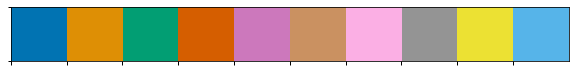

In [38]:
palette = sns.color_palette("colorblind")
sns.palplot(palette)

In [39]:
colors = [palette[7],  # scree / gray
          palette[0],  # cliff / blue
          palette[2]]  # vegetation / green

In [40]:
outdf = colorize_labels(features[COORDS], features["label"], colors)

In [41]:
output_file_path = DATADIR / "output" / PREFIX_NAME / "classification"
output_file_path.mkdir(exist_ok="True")
write_las(outdf, input_file_path, output_file_path / "pombourg-classification.las")